# Digit Recognition

In the last notebook, we did a pretty good job. We were able to extra digits from an image and then classify them. Our model performed very poorly and we mentioned two reasons for it:
1. Input images is different than training images.
2. Current features (flatten image) are very poor at capturing information.

There are many things that you can do to make our input images look similar to training images, and to make our features capture more information from the images. We will be learning some of the available techniques.

We will start by importing some libraries that we will be using. 

In [4]:
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt

some helper functions from the last notebook to read, display and process image 

In [5]:
def read_img(path):
    img = cv2.imread(path)
    return img

def plot_img(img):
    plt.axis(False)
    plt.imshow(img, cmap='gray');
    
def process_img(img, gray=False):
    img = cv2.resize(img, (28,28))
    if not gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    final = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 3, 4)
    return final.reshape(-1)

So, lets continue where we left i.e.
- read the image
- apply gaussian blur
- apply canny edge detection
- find all the contours in the images

In [3]:
digits = cv2.imread('images/digits.png')
blurred = cv2.GaussianBlur(digits, (7, 7), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(cnts)

6

## Other than training images

Machine learning models (here SVM) are very dumb. They perform really well on training data, but they don't generalize well to outside data. So, special care has to be taken while preprocessing outside data before feeding it into the model. 

Lets take a look at our digit images that we are feeding into our model. Here I'm selecting *digit 1* for better understanding because the differences in input image and training image are much more prominent. *Digit 1* is the 3rd (i.e. index = 2) element of the `cnts` list.

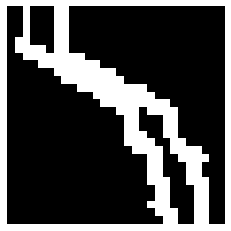

In [5]:
temp = digits.copy()
(x, y, w, h) = cv2.boundingRect(cnts[2])
roi = temp[y:y + h, x:x + w]
roi = process_img(roi)
plot_img(roi.reshape(28, 28))

This is how it look. What do you think of it? Does it look like *1*? 

All our training images are 28 x 28 pixels. So, digit 1 has a lot of padding, on either side, in all our training images. Infact every digit has padding, but here our bounding boxes are edge-to-edge. Lets solve this problem by adding some padding to all our bounding boxes.

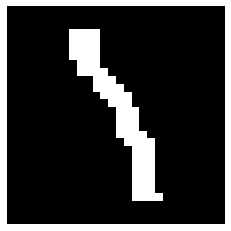

In [6]:
temp = digits.copy()
(x, y, w, h) = cv2.boundingRect(cnts[2])
x, y, w, h = x-20, y-20, w+40, h+40  # extra padding
roi = temp[y:y + h, x:x + w]
roi = process_img(roi)
plot_img(roi.reshape(28, 28))

much better now. Lets see if this helps

In [7]:
model = joblib.load('data/digit_svm.pkl')

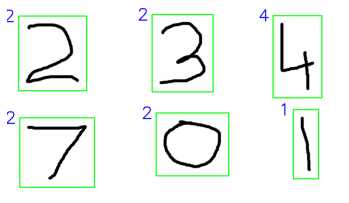

In [9]:
temp = digits.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    x, y, w, h = x-20, y-20, w+40, h+40 # extra padding
    roi = temp[y:y + h, x:x + w]
    roi = process_img(roi)
    pred = model.predict([roi])[0]
    temp = cv2.rectangle(temp, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(temp, str(pred), (x - 40, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

plot_img(temp)

We are getting 3 predictions right this time, amazing! We can already see our model improving. 

Anonther problem is that the bounding box for 1 is very tall and very thin. So, when we resize it to 28 x 28, the output looks entirely different. We need a consistent representation of digits where all images are of the same width and height, with the digit placed at the center of the image. Just like our training data.

In [10]:
import mahotas

In [14]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image

    dim = None
    if width is None:
        # calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        # calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

def extent(image, size):
    (eW, eH) = size
    if image.shape[1] > image.shape[0]:
        image = resize(image, width = eW)
    else:
        image = resize(image, height = eH)
        
    extent = np.zeros((eH, eW), dtype = "uint8") # black canvas
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX + image.shape[1]] = image
    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")
    (dX, dY) = ((size[0] // 2) - cX, (size[1] // 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)
    return extent

The `extent` function, takes two arguments. The first is an image and the second is the output size of the image (i.e. the output width and height). We first checks if the width is greater than the height of the image. If this is the case, the image is resized based on its width. Otherwise, the height is greater than the width, so the image must be resized based on its height. This is an important checks to make because it makes sure that the original aspect ratio of the image is maintained.

We then create a black canvas of the same dimensions that were passed into the function. The offsetX and offsetY are computed. These offsets indicate the starting (x, y) coordinates (in y, x order) of where the image will be placed on the canvas. 

The next step is to translate the digit so it is placed at the center of the image. We compute the weighted mean of the white pixels in the image using the `center_of_mass` function of the *mahotas package*. This function returns the weighted (x, y) coordinates of the center of the image. We then converts these (x, y) coordinates to integers rather than floats. Finally, we translates the digit so that it is placed at the center of the image.

**Note:** we will highly recommend you to look at the intermediate output. Also, google and read more about *mahotas* library and `cv2.warpAffine` function.

Lets check if this function is of any help

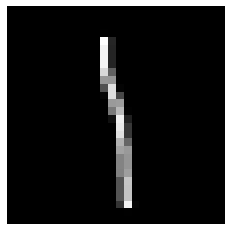

In [15]:
temp = digits.copy()

(x, y, w, h) = cv2.boundingRect(cnts[2]) # try changing 2 -> 3 or 4
x, y, w, h = x-20, y-20, w+40, h+40      # extra padding
roi = temp[y:y + h, x:x + w]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
roi = cv2.GaussianBlur(roi, (3, 3), 0)
roi = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 4)
roi = extent(roi, (28, 28))
plot_img(roi)

I would recommend you to change the contour (i.e. `cnts[id]` in the above cell) and take a look at the output for each of our digits. See if you can classify each one of them manually.

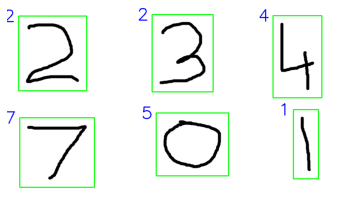

In [17]:
temp = digits.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = temp[y:y + h, x:x + w]
    x, y, w, h = x-20, y-20, w+40, h+40  # extra padding
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.GaussianBlur(roi, (3, 3), 0)
    roi = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 4)
    roi = extent(roi, (28, 28))
    roi = roi.reshape(-1)
    pred = model.predict([roi])[0]
    temp = cv2.rectangle(temp, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(temp, str(pred), (x - 40, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

plot_img(temp)

Amazing, we got 4 predictions right! In the last notebook, we got only one prediction right, just by adding some extra padding and using `extend` function we got a massive boost in our performance.

The reason we are discussing all these things is to make you realize the challenges that you face while developing a computer vision application and how to handle them. Doubt everything, look at the intermediate outputs, and write a lot of code. 

We are leaving this as an exercise for you to improve the model further. Try to make the output images look as close to training images as possible. Use all the different techniques that we learned in the course. 

Lets discuss the second reason for poor performance.

## Flatten Images

When we flatten our image, we lose all its spacial information. The SVM model don't know that the 784 values are derived from an image, for our model its just a bunch of numbers. If you shift the image by a single pixel then you will get a completely different feature vector on flattening it. There's no way for your model to know that both the features vectors are derived from the same image. 

We need to use an algorithm which is *translation-invariant* i.e. after learning a certain pattern, it should be able to recognize the same pattern anywhere in the image. Such algorithm need fewer training samples to learn representations that have generalization power. 

CNNs (in deep learning) are the best example of models that are translation-invariant. But discussing deep learning is out of the scope of the course. So, we will learn and use some classic computer vision techniques for extracting features from the image.

## HOG descriptor
Histogram of Oriented Gradients, HOG for short, operates on the gradient magnitude of the image. Computing the gradient magnitude of an image is similar to edge detection. HOG has been used successfully in many areas of computer vision and machine learning, but especially noteworthy is the detection of people in images. You can read more about HOG descriptor [here](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/).

We are going to use the HOG image descriptor to learn the representation of image digits and Support Vector Machine (SVM) to classify them.

First, we need to extract features from all our training images and train the machine learning model again.

In [1]:
from pathlib import Path

In [2]:
def load_data(base_path):
    images = []
    labels = []
    
    for folder in base_path.iterdir():
        label = int(folder.stem)
        for img_path in folder.glob('*.jpg'):
            img = read_img(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

We will load all our images in to memory

In [7]:
%%time
base_path = Path('data/trainingSet')
images, labels = load_data(base_path)
images.shape, labels.shape

Wall time: 2min 42s


((42000, 28, 28), (42000,))

42000 images and 42000 labels, everything worked fine.

Next, we need to extract HOG features from our images. Luckily for us, the scikit-image library has already implemented the HOG descriptor, so he can rely on it when computing his feature representations. We will start by importing the *feature* sub-package of *scikit-image*. The *feature* package contains many methods to extract features from images.

In [8]:
from skimage import feature
    
def describe(image):
    hist = feature.hog(image,
                    orientations = 9,
                    pixels_per_cell = (8, 8),
                    cells_per_block = (3, 3),
                    transform_sqrt = False)
    return hist

The first argument is an image. The second, *orientations*, defines how many gradient orientations will be in each histogram (i.e.,
the number of bins). The *pixelsPerCell* parameter defines the number of pixels that will fall into each cell. When computing the HOG descriptor over an image, the image will be partitioned into multiple cells, each of size *pixelsPerCell* × *pixelsPerCell*. A histogram of gradient magnitudes will then be computed for each cell. HOG will then normalize each of the histograms according to the number of cells that fall into each block using the *cellsPerBlock* argument.

Optionally, HOG can apply power law compression (taking the log/square-root of the input image), which can lead to better accuracy of the descriptor.

Time to extract features from all the images

In [9]:
data = [describe(img) for img in images]

**Note:** Here, we are not splitting our data into train and test set for simplicity.

lets train our SVM model on the feautures extracted from the images . . .

In [10]:
from sklearn import svm
svm = svm.SVC(random_state = 0)
svm.fit(data, labels)
svm.score(data, labels)

0.9840238095238095

In [11]:
joblib.dump(svm, 'digit_svm.pkl')

['digit_svm.pkl']

Lets copy the code from above and change the line that flattens the image to call `describe` function.

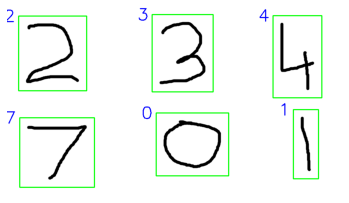

In [23]:
temp = digits.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = temp[y:y + h, x:x + w]
    x, y, w, h = x-20, y-20, w+40, h+40  # extra padding
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.GaussianBlur(roi, (3, 3), 0)
    roi = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 4)
    roi = center_extent(roi, (28, 28))
    feat = describe(roi)   # extracting features
    pred = svm.predict([feat])[0]
    temp = cv2.rectangle(temp, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(temp, str(pred), (x - 40, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

plot_img(temp)

Hurry, we got all the digits right! HOG is amazingly powerful and fast. we can easily convert it into a real-time application. We will leave that as an exercise for you to try. 

Just like HOG, there are many other techniques for extracting features from images. Some of the very famous onces are SIFT, SURF, FAST and ORB. We wil be learning about them in the next notebook.

## Questionaire

- What are the most important things to take care of when buildig a computer vision application?
- What are the mistakes that people often commit?
- How can we extract more meaningful features (or information) from images? Name a few techniques.